### imports and setup

In [2]:
# # google colab setup (comment out this cell if running locally)
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)
# %cd "/content/drive/My Drive/_research ML AQ/lorenz 96 gnn" # so we can access pre-generated lorenz data
# !pip3 install spektral

In [21]:
# ipython extension to autoreload imported modules so that any changes will be up to date before running code in this nb
%load_ext autoreload 
%autoreload 2

# Load the TensorBoard notebook extension
%load_ext tensorboard

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [4]:
# import packages
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from lorenz import lorenzDataset, DEFAULT_TIME_RESOLUTION
from plotters import plot_data
from tuning import make_train_GCN, make_train_GCN3, plot_model_results
from models import NaiveConstant, NaiveZero

from spektral.data import MixedLoader

from datetime import datetime

2023-02-14 11:07:15.537129: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
# check that GPU is set up
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print('no GPU device found')
else:
    print('found GPU at: {}'.format(device_name))
print('num GPUs available:', len(tf.config.list_physical_devices("GPU")))

no GPU device found
num GPUs available: 0


2023-02-14 11:07:21.944450: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### prepare data

In [6]:
# only uncomment each line if testing a non-default parameter
dataset = lorenzDataset(
    n_samples=10_000,
    # input_steps=2 * DEFAULT_TIME_RESOLUTION,  # 2 days
    # output_delay=1 * DEFAULT_TIME_RESOLUTION,  # 1 day
    # output_steps=1,
    min_buffer=-3 * DEFAULT_TIME_RESOLUTION,
    # rand_buffer=False,
    # K=36,
    # F=8,
    # c=10,
    # b=10,
    # h=1,
    # coupled=True,
    # time_resolution=DEFAULT_TIME_RESOLUTION,
    # seed=42
)

reading Lorenz data from stored file


In [7]:
train = dataset[:int(0.7 * dataset.n_graphs)]
val = dataset[int(0.7 * dataset.n_graphs):int(0.9 * dataset.n_graphs)]
test = dataset[int(0.9 * dataset.n_graphs):]


In [8]:
train_loader = MixedLoader(dataset=train, batch_size=32, shuffle=False)
val_loader = MixedLoader(dataset=val, batch_size=32, shuffle=False)


In [9]:
# TODO: store normalized train/val/test data

# normalize data
start = datetime.now()
X1_mean, X1_std, X2_mean, X2_std = train.get_mean_std()
finish_get_means = datetime.now()
print('time to get means:', finish_get_means - start)

train.normalize(X1_mean, X1_std, X2_mean, X2_std)
val.normalize(X1_mean, X1_std, X2_mean, X2_std)
test.normalize(X1_mean, X1_std, X2_mean, X2_std)
finish_normalize = datetime.now()

print('time to normalize data:', finish_normalize - finish_get_means)

time to concat: 0:00:00.818502
time to get std&mean from X1: 0:00:01.222609
time to get std&mean from X2: 0:00:00.389236
time to get means: 0:00:02.497316
time to normalize data: 0:00:01.057759


inspect data
(commented out because it takes too long to plot so many data points and I'm confident I know what it looks like)

In [10]:
# fig, (ax0, ax1) = plot_data(train, val, test, node=0)

# plt.tight_layout()
# plt.show()

## sandbox

### 3-layer GCN

#### train to overfit on single data point

In [9]:
model, history, fname = make_train_GCN3(train,
                                        val,
                                        activation="relu",
                                        epochs=30,
                                        eval_val=True,
                                        early_stopping=True,
                                        early_stopping_patience=5,
                                        early_stopping_start_from_epoch=10,
                                        tensorboard=True)


Epoch 1/100
219/219 [==============================] - 18s 74ms/step - loss: 36.1343 - val_loss: 1.1918
Epoch 2/100
 45/219 [=====>........................] - ETA: 11s - loss: 1.1531

32/32 [==============================] - 1s 23ms/step


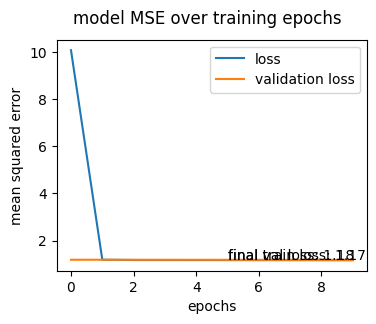

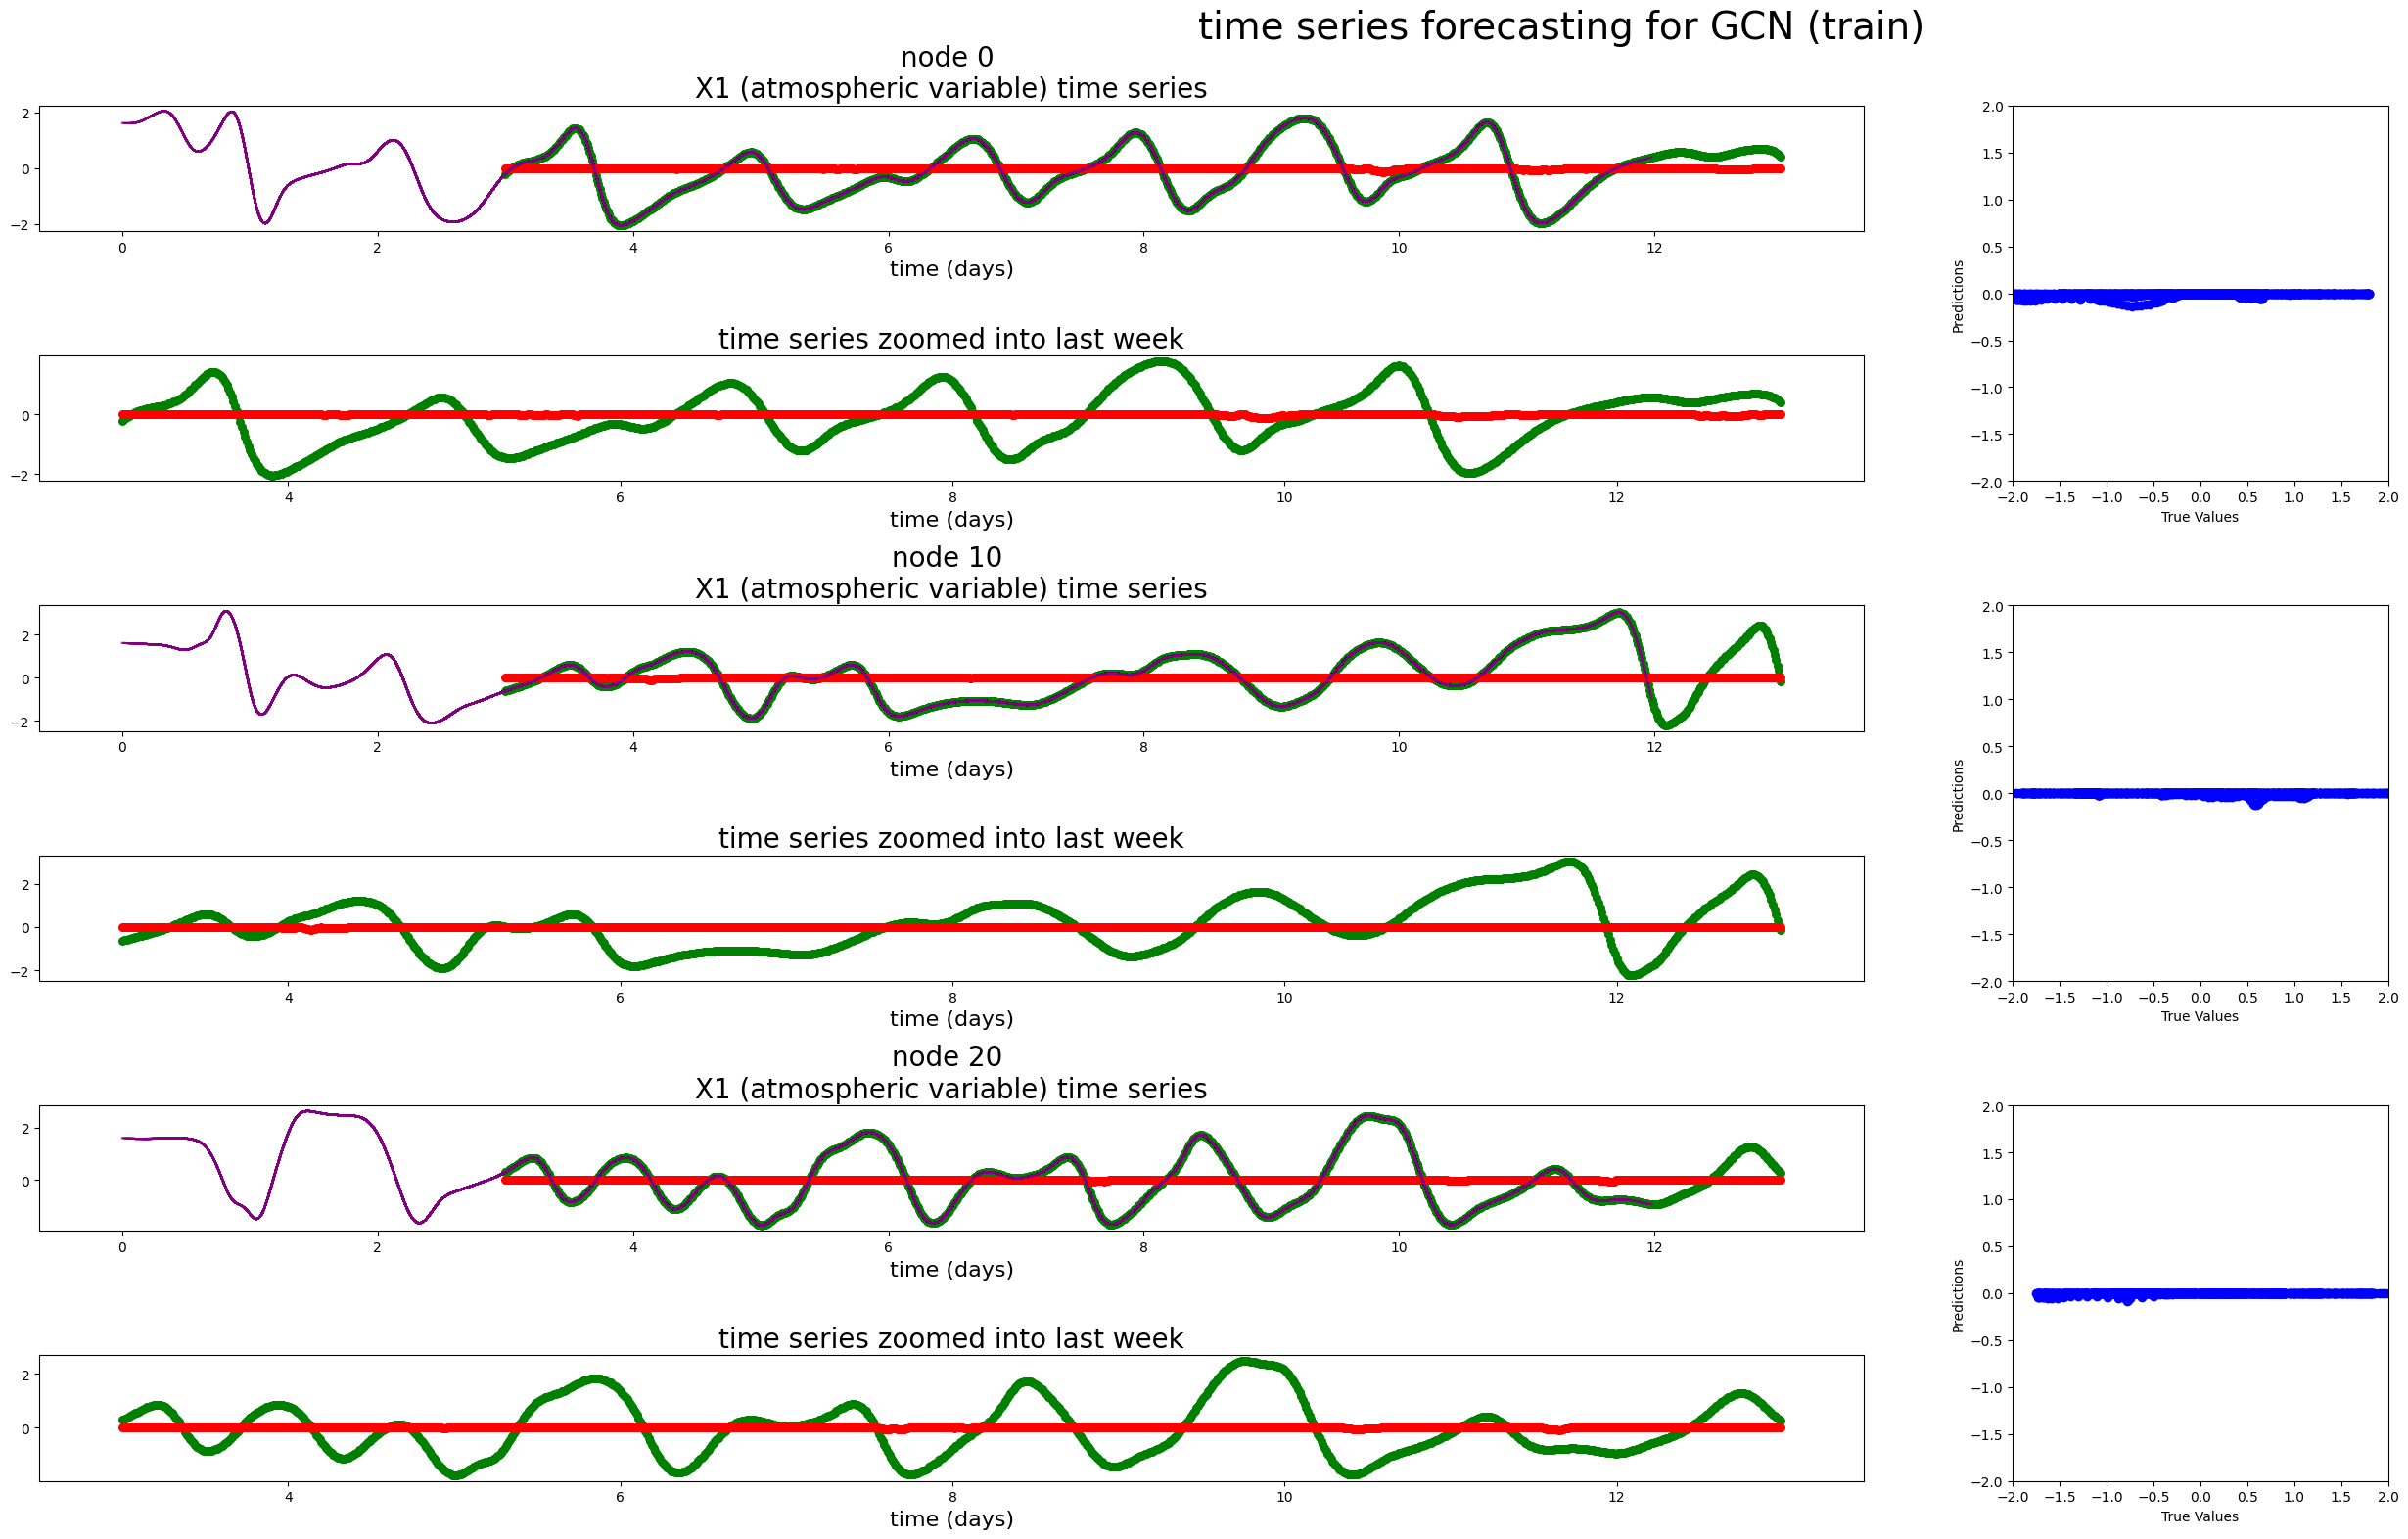

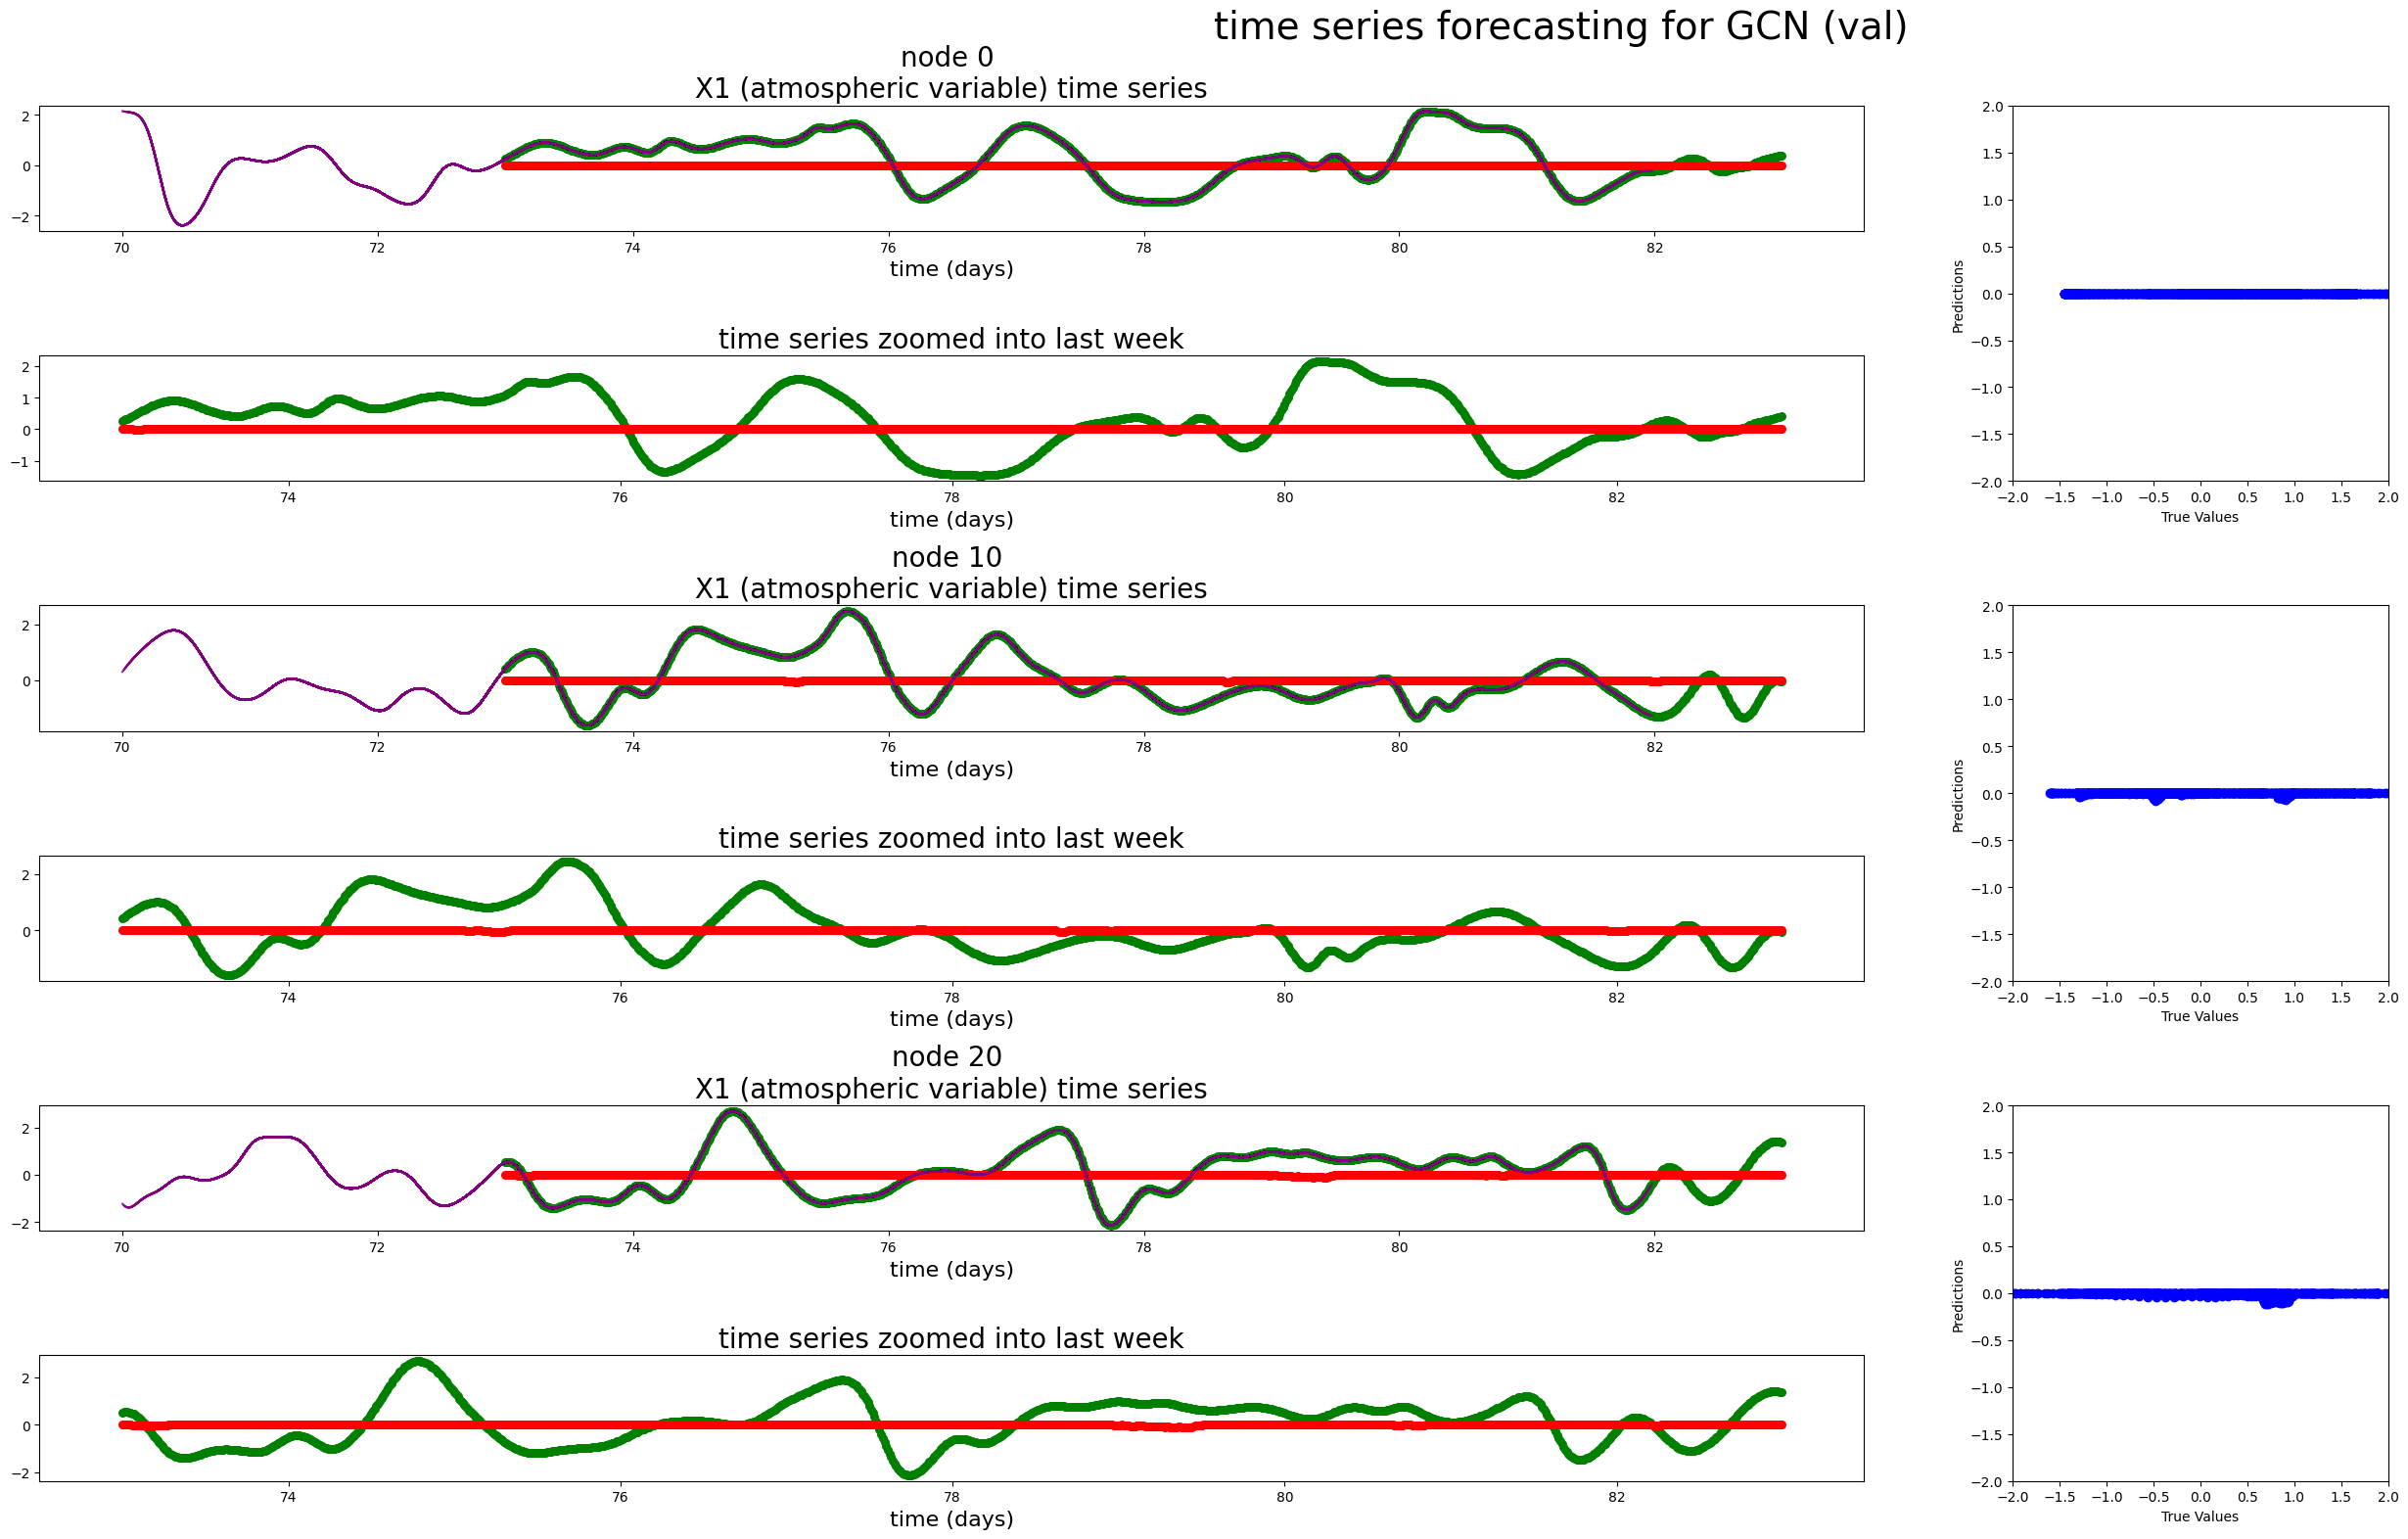

In [ ]:
fig_train_loss, fig_train_pred, fig_val_pred = plot_model_results(
    train[:1000], val[:1000], model, history, epochs=5)

ok, so even though we added complexity, it's still not learning any variation. maybe we need to train for longer epochs?

In [11]:
model2, history2, fname2 = make_train_GCN3(train,
                                           val,
                                           activation="relu",
                                           epochs=100,
                                           eval_val=True,
                                           early_stopping=True,
                                           early_stopping_patience=10,
                                           early_stopping_start_from_epoch=50,
                                           tensorboard=True,
                                           verbose=2)


Epoch 1/100
219/219 - 15s - loss: 7.8082 - val_loss: 1.1891 - 15s/epoch - 70ms/step
Epoch 2/100
219/219 - 14s - loss: 1.1805 - val_loss: 1.1885 - 14s/epoch - 64ms/step
Epoch 3/100
219/219 - 15s - loss: 1.1773 - val_loss: 1.1879 - 15s/epoch - 66ms/step
Epoch 4/100
219/219 - 15s - loss: 1.1768 - val_loss: 1.1873 - 15s/epoch - 68ms/step
Epoch 5/100
219/219 - 15s - loss: 1.1750 - val_loss: 1.1864 - 15s/epoch - 69ms/step
Epoch 6/100
219/219 - 15s - loss: 1.1735 - val_loss: 1.1855 - 15s/epoch - 67ms/step
Epoch 7/100
219/219 - 15s - loss: 1.1722 - val_loss: 1.1843 - 15s/epoch - 68ms/step
Epoch 8/100
219/219 - 15s - loss: 1.1699 - val_loss: 1.1806 - 15s/epoch - 67ms/step
Epoch 9/100
219/219 - 15s - loss: 1.1657 - val_loss: 1.1763 - 15s/epoch - 66ms/step
Epoch 10/100
219/219 - 17s - loss: 1.1620 - val_loss: 1.1742 - 17s/epoch - 76ms/step
Epoch 11/100
219/219 - 16s - loss: 1.1621 - val_loss: 1.1731 - 16s/epoch - 75ms/step
Epoch 12/100
219/219 - 14s - loss: 1.1582 - val_loss: 1.1710 - 14s/epoch -

32/32 [==============================] - 1s 21ms/step


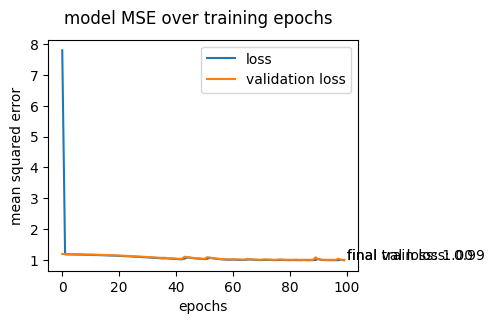

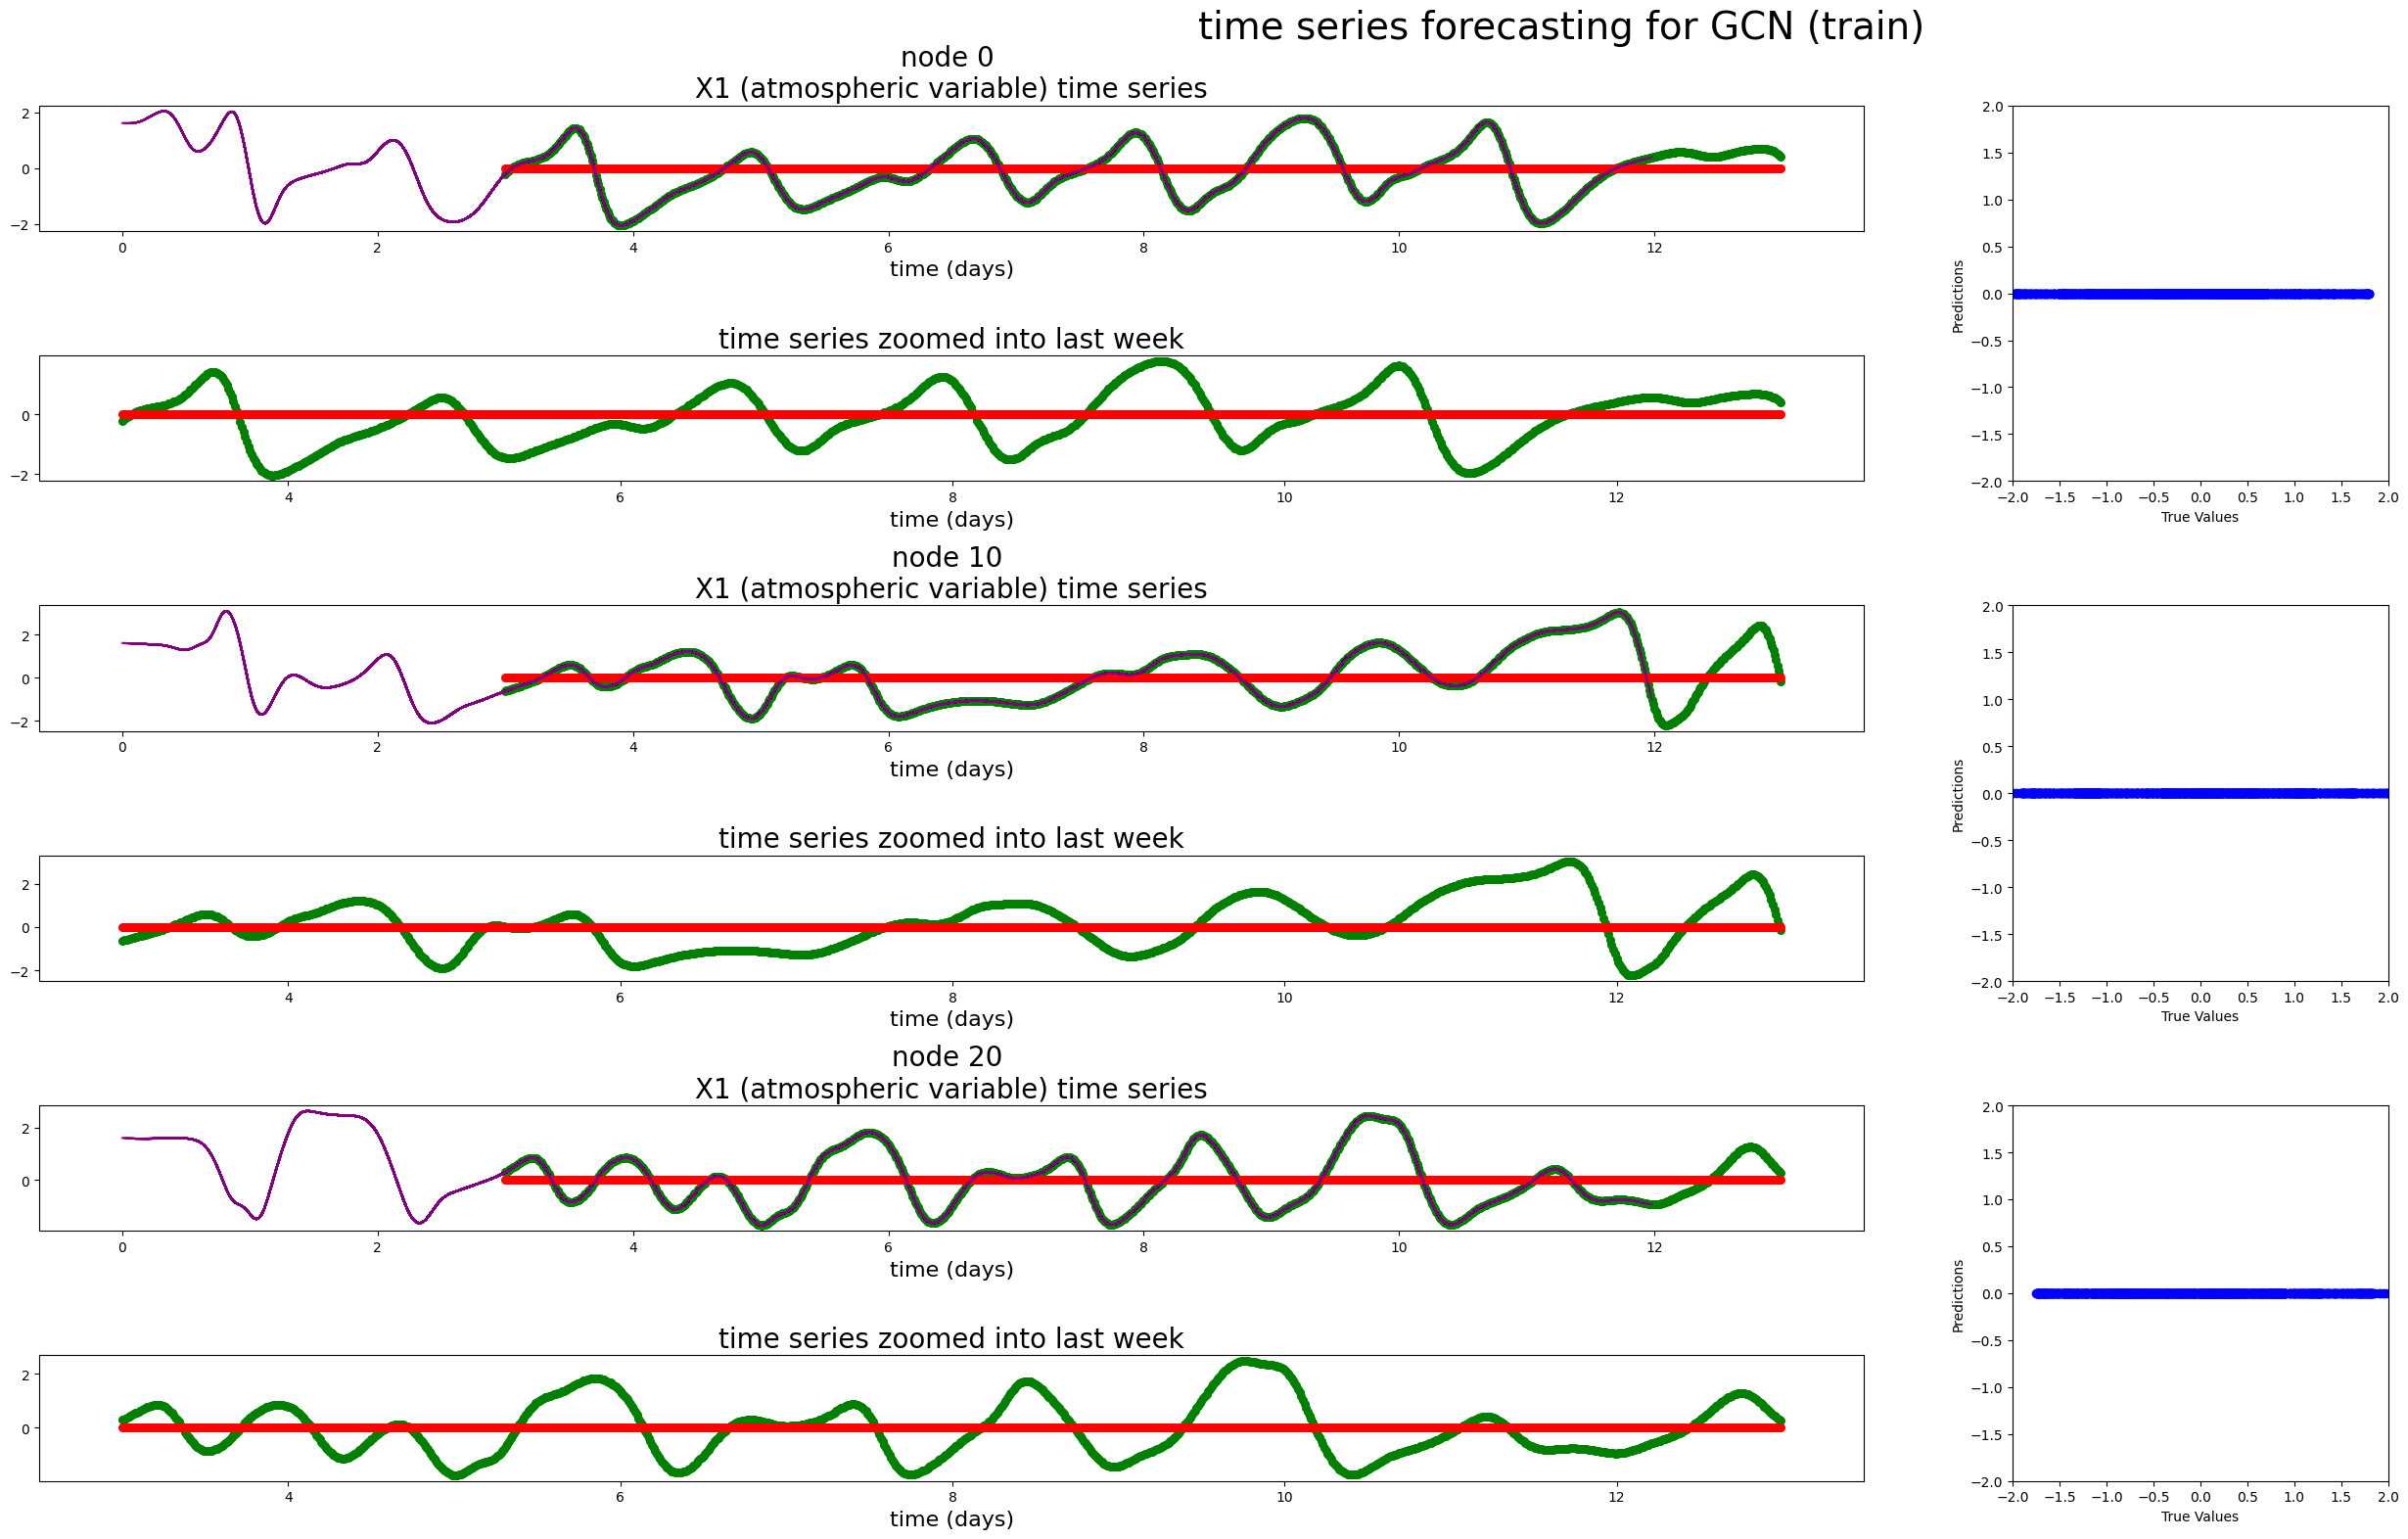

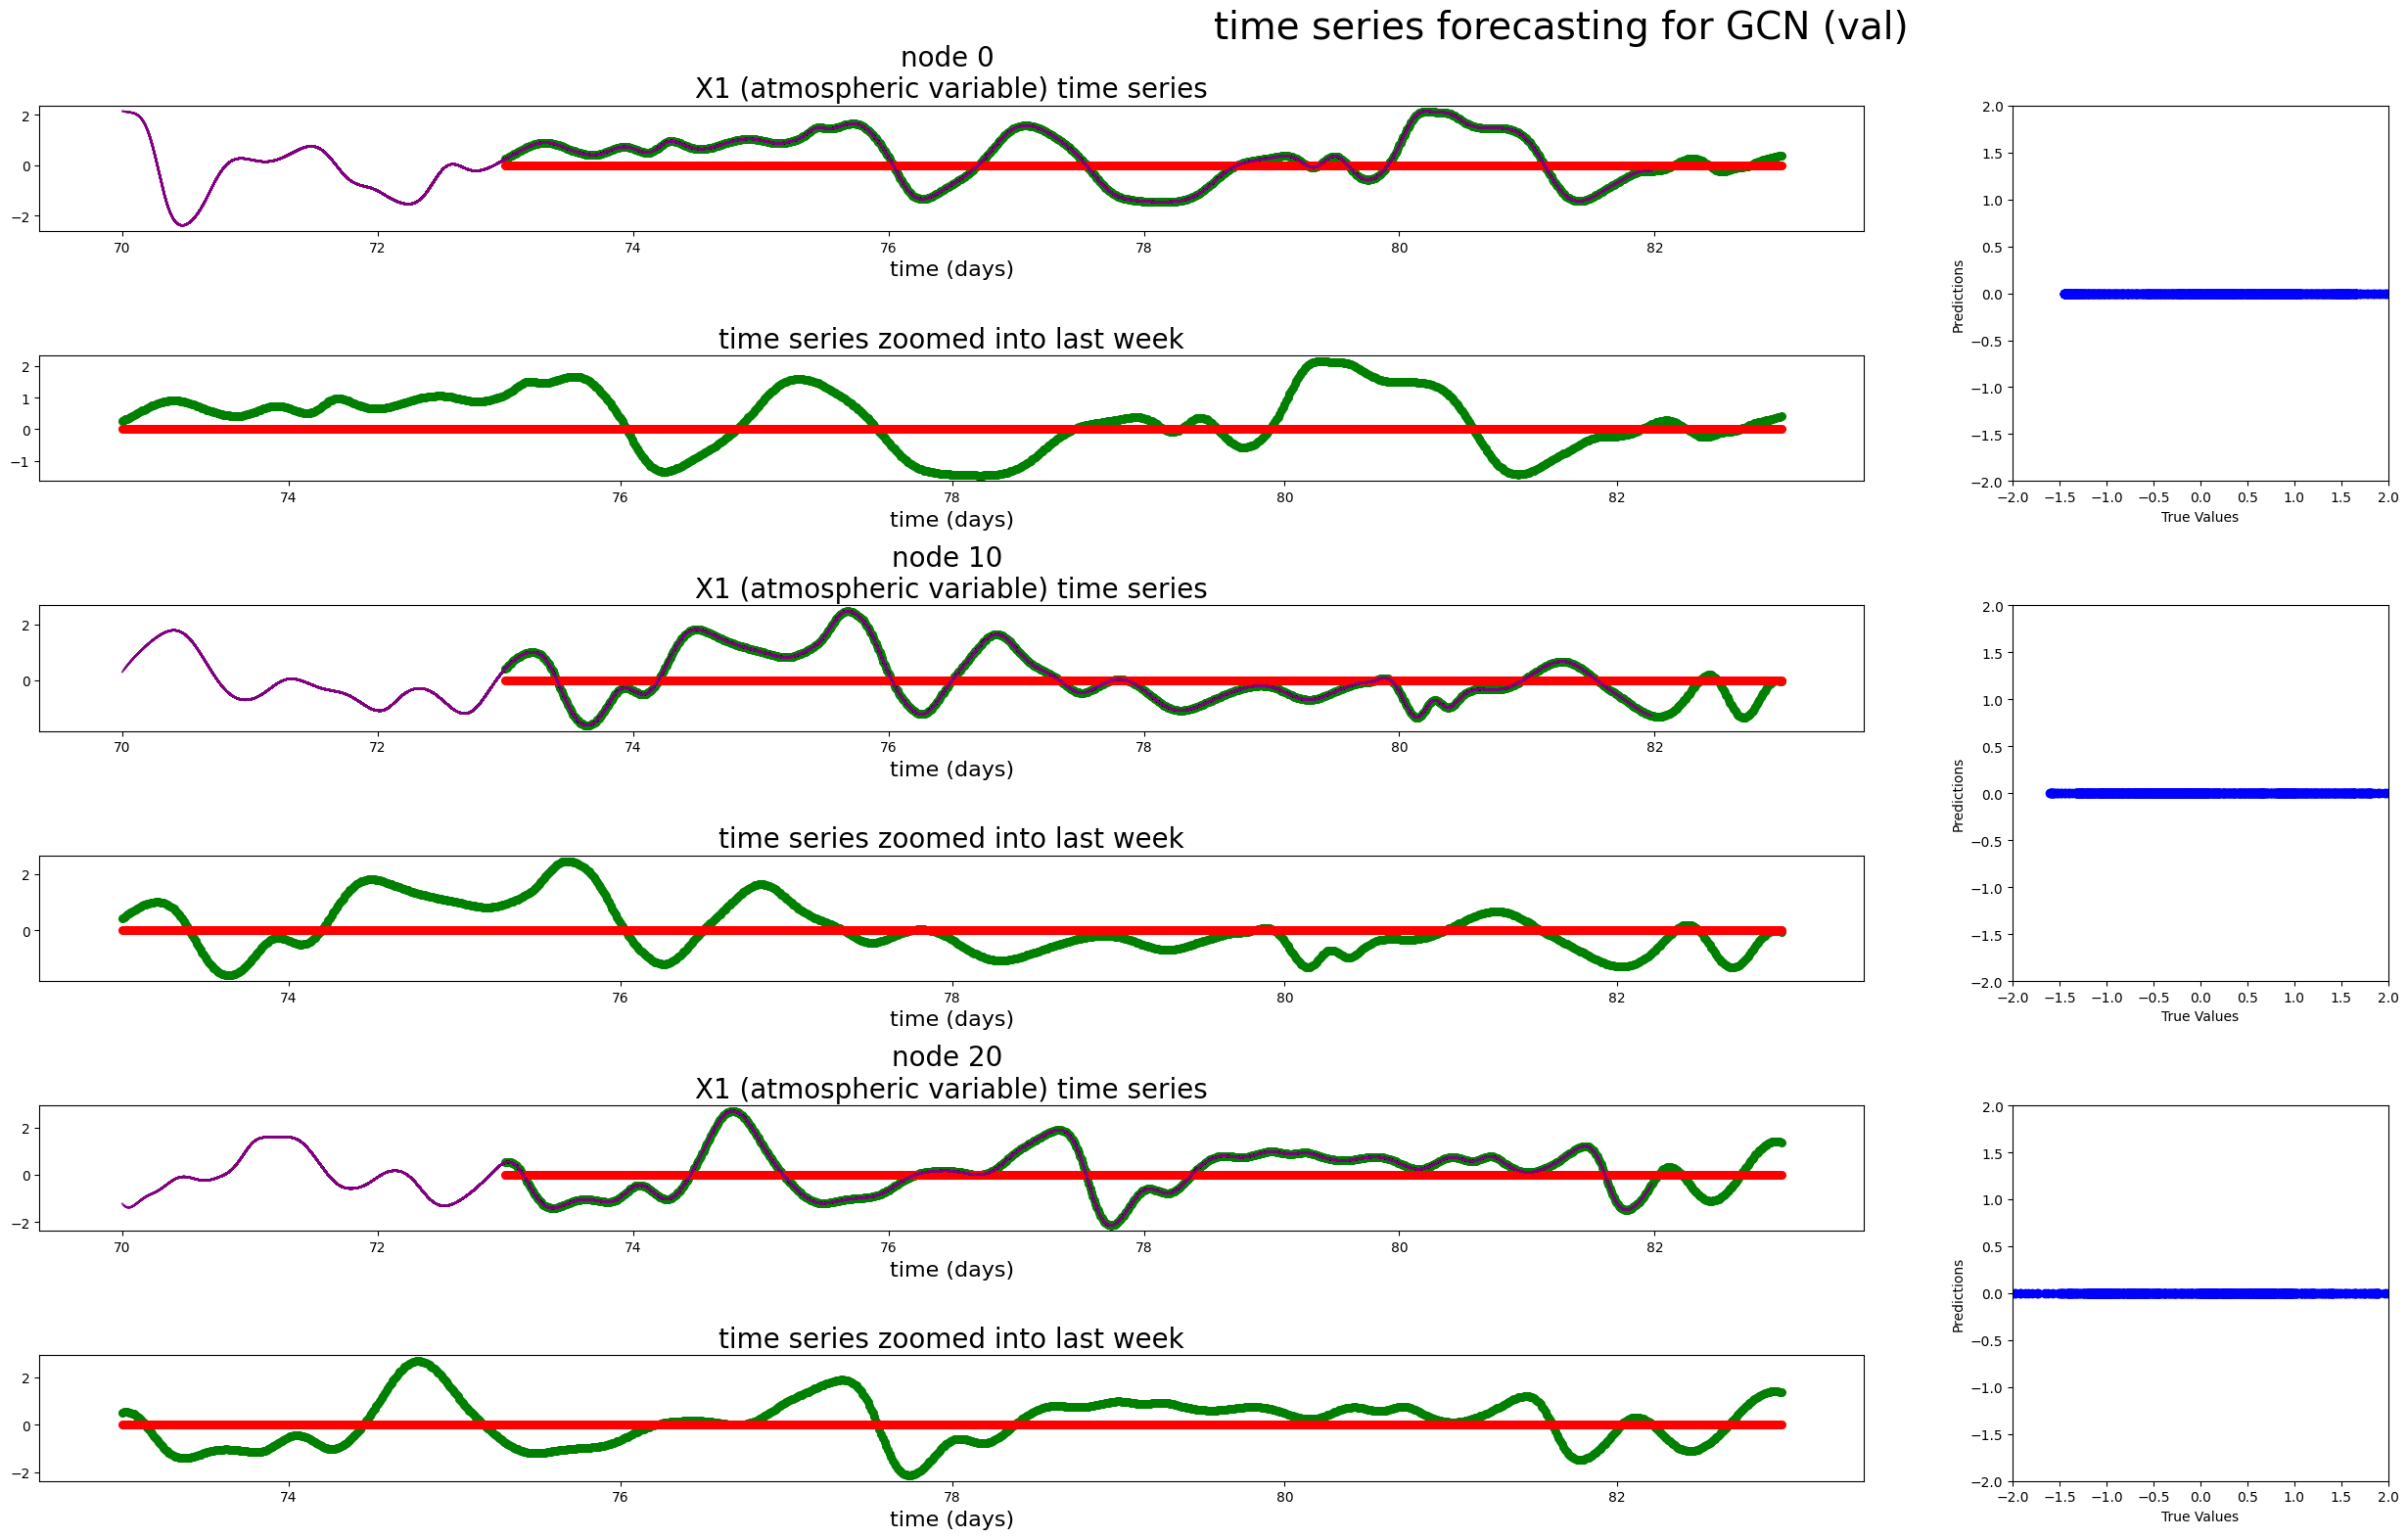

In [12]:
fig_train_loss, fig_train_pred, fig_val_pred = plot_model_results(
    train[:1000], val[:1000], model2, history2, model_name='GCN', epochs=100)